In [1]:
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from minisom import MiniSom

In [2]:
# trains a SOM on the input data
def fit_som(data: np.ndarray, grid: Tuple[int, int] = (22, 22), seed: int = 42) -> MiniSom:
    rows, cols = grid  # SOM grid dimensions set to 22x22
    som = MiniSom(
        x=rows, y=cols,
        input_len=data.shape[1],         # number of features
        sigma=3.0,                       # spread of the neighborhood
        learning_rate=0.5,               # speed of learning
        neighborhood_function="gaussian",# type of neighborhood function
        random_seed=seed                 # for reproducibility
    )
    som.random_weights_init(data)       
    som.train_batch(data, num_iteration=10_000, verbose=False)  # train the SOM
    return som

# create a lookup table from each SOM node BMU to a majority label
def majority_vote_lookup(som: MiniSom, data: np.ndarray, labels: np.ndarray) -> Dict[Tuple[int, int], int]:
    vote: Dict[Tuple[int, int], List[int]] = {}

    for vec, lbl in zip(data, labels):                  # go through each data point and its label
        bmu = som.winner(vec)                           # find best-matching unit (BMU) for the vector
        vote.setdefault(bmu, []).append(lbl)            # collect all labels that map to this BMU

    # assign each BMU the most common label (rounded average)
    return {bmu: int(round(np.mean(v))) for bmu, v in vote.items()}

# predict labels for new data using the trained SOM and the vote map
def predict_som(som: MiniSom, vote_map: Dict[Tuple[int, int], int], data: np.ndarray) -> np.ndarray:
    # for each input vector, find its BMU and use the vote_map to assign a predicted label
    return np.array([vote_map.get(som.winner(v), 0) for v in data])


In [3]:
import time
import psutil
import os


# performs cross-validation using a Self-Organizing Map (SOM)
def som_cross_validate(Syn_df: pd.DataFrame, feature_columns: List[str], grid: Tuple[int, int] = (22, 22)) -> List[float]:
    accuracies = []
    process = psutil.Process(os.getpid())
    oof_true, oof_score = [], []
    
    # resource monitoring starting
    overall_start_time = time.time()
    overall_start_ram = process.memory_info().rss / 1024 / 1024  # in MB
    overall_start_cpu = psutil.cpu_percent(interval=1)

    # loop over each fold in the dataset
    for fold in sorted(Syn_df["Fold"].unique()):
        train_df = Syn_df[Syn_df["Fold"] != fold]
        validate_df = Syn_df[Syn_df["Fold"] == fold]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df[feature_columns])
        X_validate = scaler.transform(validate_df[feature_columns])
        y_train = train_df["Label"].values
        y_validate = validate_df["Label"].values

        som = fit_som(X_train, grid)
        vote_map = majority_vote_lookup(som, X_train, y_train)
        y_predict = predict_som(som, vote_map, X_validate)
        
        # plot U-Matrix for each fold
        plt.figure(figsize=(10, 8))
        u_matrix = som.distance_map()
        plt.imshow(u_matrix, cmap='bone_r')
        plt.colorbar(label='Distance')
        plt.title(f'SOM U-Matrix - Fold {fold+1}')
        plt.savefig(f"som_umatrix_fold_{fold+1}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()

        # accuracy
        acc = (y_predict == y_validate).mean()
        accuracies.append(float(acc))
        print(f"Fold {fold+1}: accuracy = {acc:.4f}")

        dists  = np.array([som.quantization_error(np.array([v])) for v in X_validate])
        scores = -dists                         # higher = “more like map (attack)”

        oof_true.extend(y_validate.tolist())
        oof_score.extend(scores.tolist())
        
    y_bin = (np.array(oof_score) > 0).astype(int)

    cm = confusion_matrix(oof_true, y_bin)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap="Blues")
    plt.title("SOM Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(oof_true, oof_score)
    RocCurveDisplay(fpr=fpr, tpr=tpr,
                roc_auc=auc(fpr, tpr)).plot()
    plt.title("SOM ROC ")
    plt.show()

    prec, rec, _ = precision_recall_curve(oof_true, oof_score)
    PrecisionRecallDisplay(precision=prec, recall=rec).plot()
    plt.title("SOM PR")
    plt.show()
    
    # end of resource monitoring
    overall_end_time = time.time()
    overall_end_ram = process.memory_info().rss / 1024 / 1024  # in MB
    overall_end_cpu = psutil.cpu_percent(interval=1)

    # results
    print("\n══════ SOM Validation Summary ══════")
    for i, a in enumerate(accuracies, 1):
        print(f"Fold {i}: {a:.4f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"Standard Deviation: {np.std(accuracies):.4f}")

    # resources usesd
    print("\n Overall Training Stats ")
    print(f"Total Training Time: {overall_end_time - overall_start_time:.2f} seconds")
    print(f"Total RAM Usage Increase: {overall_end_ram - overall_start_ram:.2f} MB")
    print(f"CPU Usage (at final check): {overall_end_cpu}%")

    return accuracies

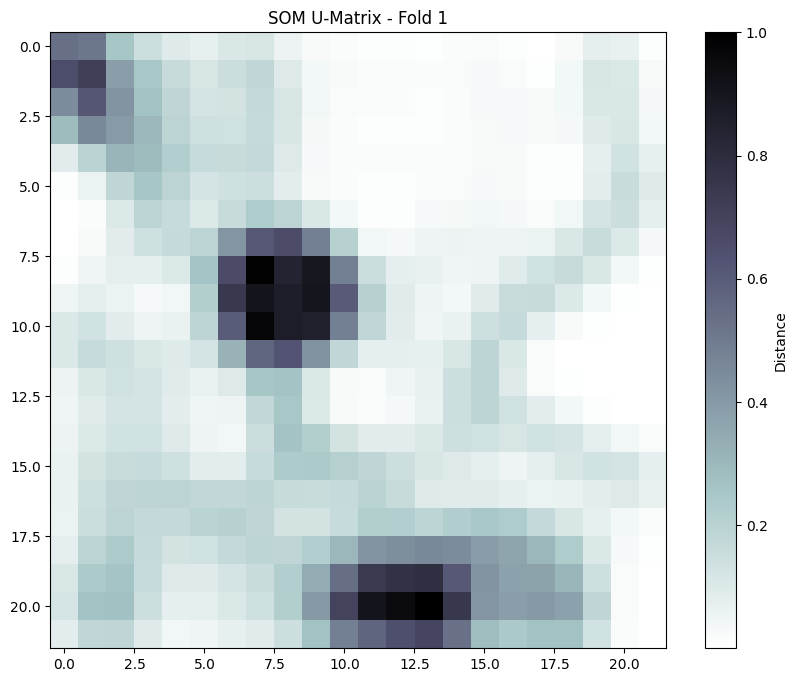

Fold 1: accuracy = 0.9979


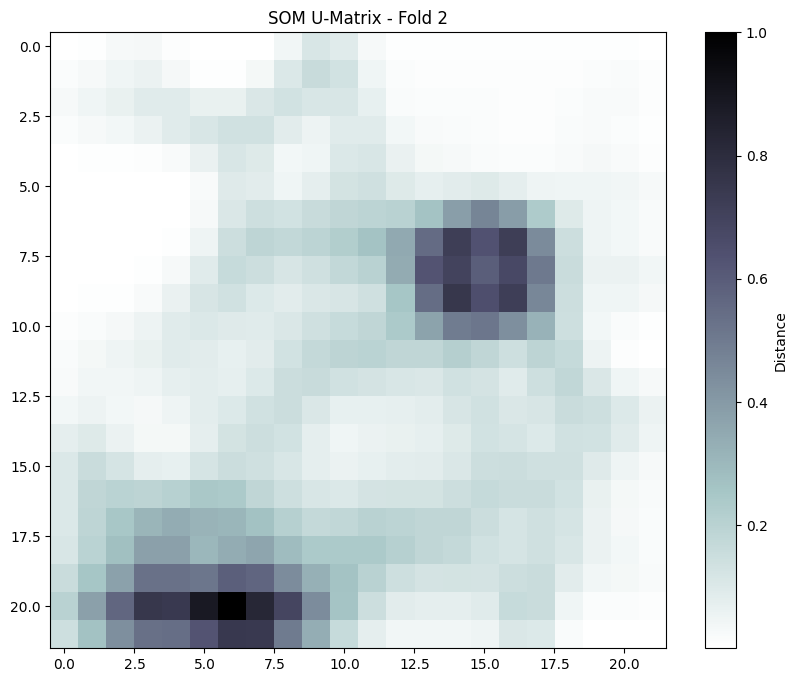

Fold 2: accuracy = 0.9984


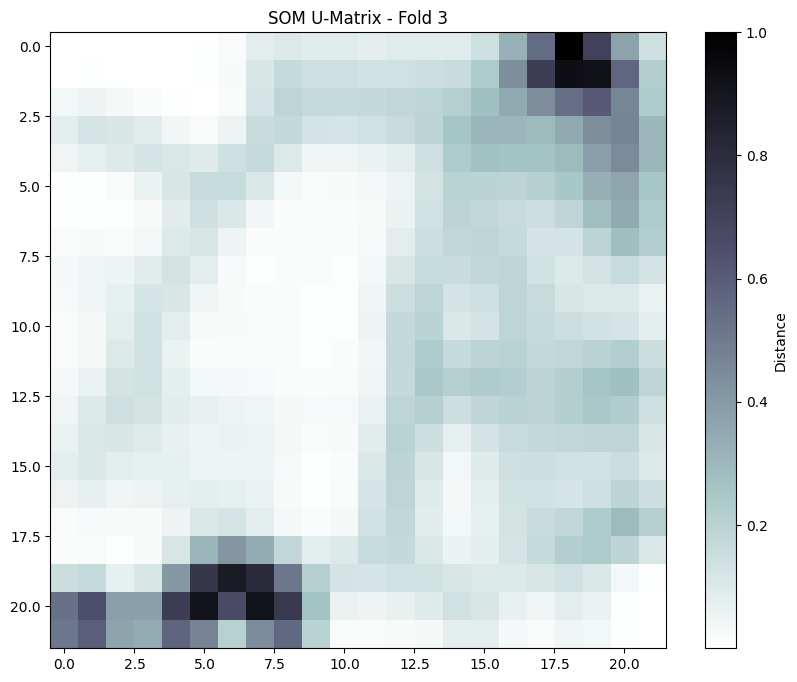

Fold 3: accuracy = 0.9958


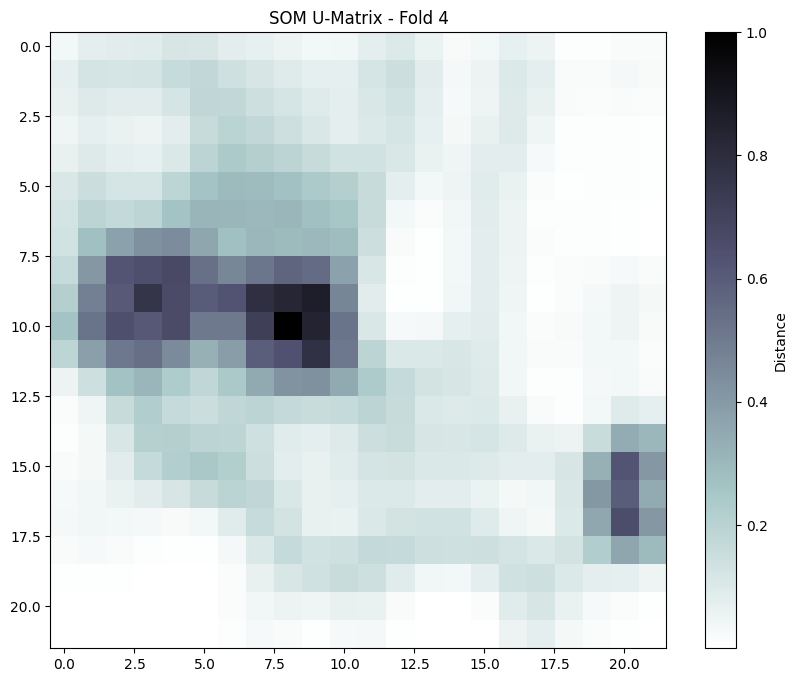

Fold 4: accuracy = 0.9974


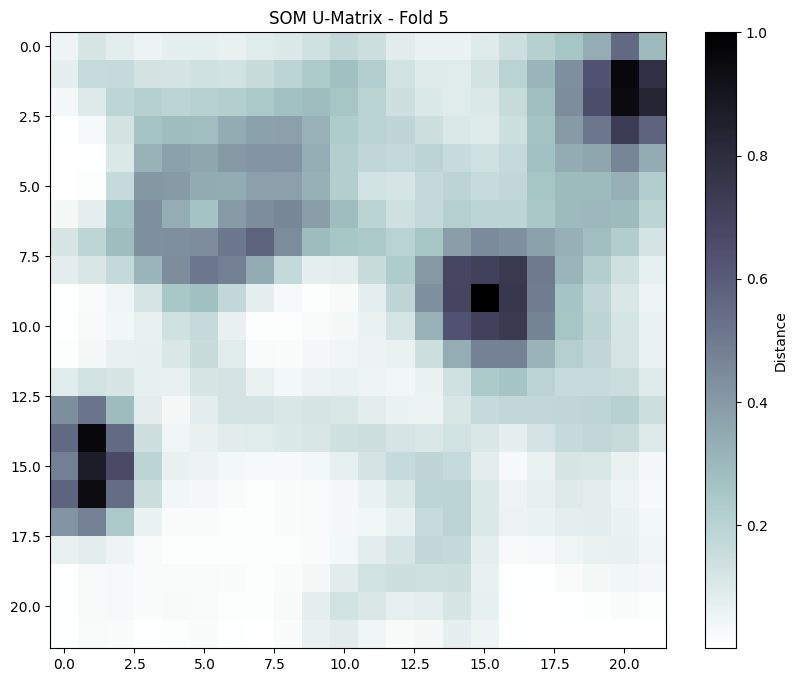

Fold 5: accuracy = 0.9964


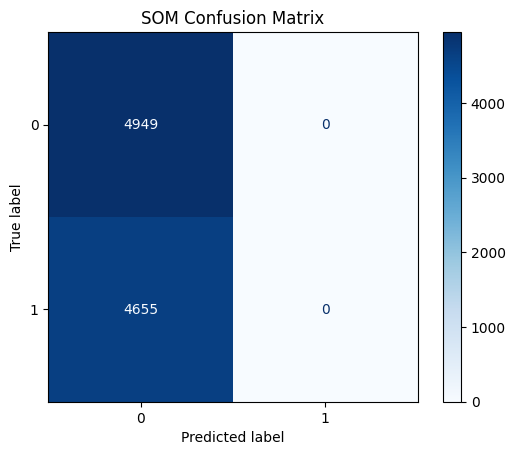

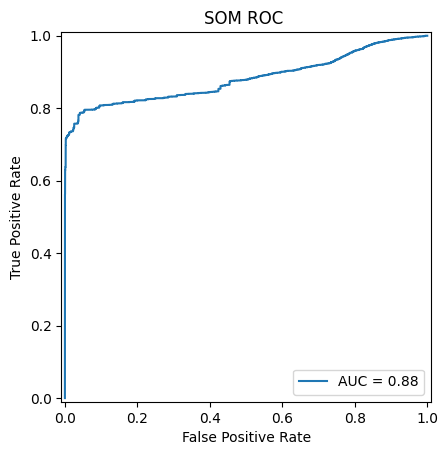

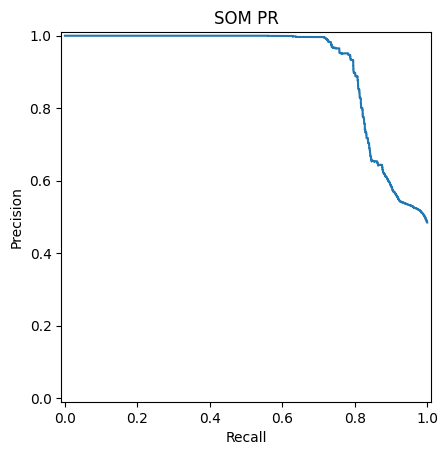


══════ SOM Validation Summary ══════
Fold 1: 0.9979
Fold 2: 0.9984
Fold 3: 0.9958
Fold 4: 0.9974
Fold 5: 0.9964
Mean Accuracy: 0.9972
Standard Deviation: 0.0010

 Overall Training Stats 
Total Training Time: 6.66 seconds
Total RAM Usage Increase: 31.69 MB
CPU Usage (at final check): 10.7%

Final SOM Cross-Validation Results:
Fold Accuracies: [0.9979177511712649, 0.9984383133784487, 0.9958355023425299, 0.9973971889640812, 0.9963541666666667]


In [4]:
if __name__ == "__main__":
    # Load the dataset
    Syn_df = pd.read_csv("D:\Coding Projects\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\Data\K5_Dataset.csv")

    # select first 12 feature columns (exclude label and fold info)
    feature_columns = Syn_df.columns.difference(["Label", "Fold"]).tolist()[:12]

    # run cross-validation using a Self-Organizing Map
    accs = som_cross_validate(Syn_df, feature_columns)
    print("\nFinal SOM Cross-Validation Results:")
    print(f"Fold Accuracies: {accs}")

    

## saving the model as PDF

In [5]:
import os
os.getcwd()

'd:\\Coding Projects\\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\\Taulant Matarova'

In [7]:
!jupyter nbconvert --to webpdf "d:\\Coding Projects\\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\\Taulant Matarova\\SOM model final.ipynb"

[NbConvertApp] Converting notebook d:\\Coding Projects\\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\\Taulant Matarova\\SOM model final.ipynb to webpdf
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 326808 bytes to d:\Coding Projects\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\Taulant Matarova\SOM model final.pdf
